In [2]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import binary_dilation
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
def log_func(x, a, b, c):
    return a * np.log(x + b) + c
parquet_file_path = 'SimulationResults/UltimateAnalysis/Survivability/Survivability.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/Survivability/Survivability.pickle'

In [3]:
def analyze_matrix(pickle_data):
    matrix_phages = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][0])))
    matrix_bacteria = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][0])))
    matrix_resources = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][0])))
    def process_resource(i, r_matrix_value):
        print("querying on r_matrix_value=", r_matrix_value)
        ddf = dd.read_parquet(
            parquet_file_path,
            engine='pyarrow',
            include_partition_columns=True,
            gather_statistics=True,
            dtype_backend='pyarrow',
            filters=[("r_matrix", "==", str(r_matrix_value))]
        )
        resource_survivability = np.zeros(len(pickle_data['param_values_list_combination'][0]))
        bacteria_survivability = np.zeros(len(pickle_data['param_values_list_combination'][0]))
        phage_survivability = np.zeros(len(pickle_data['param_values_list_combination'][0]))
        for j, e_matrix_value in enumerate(pickle_data['param_values_list_combination'][0]):
            simulation_results = ddf.query(f"e_matrix == {e_matrix_value}").compute()
            y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[:, :]
            resources_last_value_extracted = y_values[:pickle_data['agent_type_count'][0], -1]
            uninfected_bacteria_last_value_extracted = y_values[pickle_data['agent_type_count'][0]:pickle_data['agent_type_count'][0] + pickle_data['agent_type_count'][1], -1]
            infected_bacteria_last_value_extracted = y_values[pickle_data['agent_type_count'][0] + pickle_data['agent_type_count'][1]:pickle_data['agent_type_count'][0] + pickle_data['agent_type_count'][1]+pickle_data['agent_type_count'][2], -1]
            infected_bacteria_last_value_extracted = infected_bacteria_last_value_extracted.reshape(20, 4)
            phage_last_value_extracted = y_values[pickle_data['agent_type_count'][0] + pickle_data['agent_type_count'][1] + pickle_data['agent_type_count'][2]:, -1]
            sum_resources = np.sum(resources_last_value_extracted > 1)
            sum_uninfected_bacteria = np.sum(uninfected_bacteria_last_value_extracted > 1)
            sum_infected_bacteria = np.sum(infected_bacteria_last_value_extracted > 1)
            sum_phage = np.sum(phage_last_value_extracted > 1)
            resource_survivability[j] = sum_resources
            bacteria_survivability[j] = sum_uninfected_bacteria + sum_infected_bacteria
            phage_survivability[j] = sum_phage
        return resource_survivability, bacteria_survivability, phage_survivability

    results = Parallel(n_jobs=-1)(
        delayed(process_resource)(i, resource_value)
        for i, resource_value in enumerate(pickle_data['param_values_list_combination'][1])
    )

    for i, (col1, col2, col3) in enumerate(results):
        matrix_phages[i, :] = col1
        matrix_bacteria[i, :] = col2
        matrix_resources[i, :] = col3
    return matrix_phages, matrix_bacteria, matrix_resources

In [4]:
def create_plot(matrix_phages, matrix_bacteria, matrix_resources, pickle_data, save_fig=None):
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    for i, matrix in enumerate([matrix_resources, matrix_bacteria, matrix_phages]):
        xtick_indices = np.arange(len(pickle_data['param_values_list_combination'][1]), step=5)
        ytick_indices = np.arange(len(pickle_data['param_values_list_combination'][0]), step=5)
        xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[xtick_indices]]
        ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[ytick_indices]]

        ax[i].imshow(matrix, cmap='viridis', aspect='auto', interpolation='nearest')

        ax[i].set_xlabel('r values', fontsize=16)
        ax[i].set_ylabel('e values', fontsize=16)
        ax[i].set_xticks(xtick_indices)
        ax[i].set_xticklabels(xtick_labels, fontsize=8, rotation=-90)
        ax[i].set_yticks(ytick_indices)
        ax[i].set_yticklabels(ytick_labels, fontsize=8)
        ax[i].set_title(['Phage Survivability', 'Uninfected + Infected Bacteria Survivability', 'Resource Survivability'][i], fontsize=16)
        cax = ax[i].imshow(matrix, cmap='viridis', aspect='auto')
        if i == 0 or i == 1:
            cax.set_clim(0, 20)
        else:
            cax.set_clim(0, 10)

        plt.colorbar(cax, ax=ax[i], orientation='vertical', fraction=0.02, pad=0.04, label='Count')
    plt.suptitle(r'Number of Phages, Bacteria, and Resource That Survived in a Large $20\times20\times10$ System', fontsize=20)
    # Remove individual colorbars and create a single shared colorbar
    plt.tight_layout()
    im = ax[0].imshow(matrix_resources, cmap='viridis', aspect='auto', interpolation='nearest')
    if save_fig is not None:
        plt.savefig(f'LatexReport/Images/Plots/Created/PP/{save_fig}', dpi=300, bbox_inches='tight')
    plt.show()

parameter_names_used ['e_matrix', 'r_matrix']
param_values_list_combination [[0.05, 0.05408163265306123, 0.05816326530612245, 0.06224489795918368, 0.0663265306122449, 0.07040816326530613, 0.07448979591836735, 0.07857142857142857, 0.0826530612244898, 0.08673469387755103, 0.09081632653061225, 0.09489795918367347, 0.0989795918367347, 0.10306122448979593, 0.10714285714285715, 0.11122448979591837, 0.1153061224489796, 0.11938775510204082, 0.12346938775510205, 0.1275510204081633, 0.1316326530612245, 0.13571428571428573, 0.13979591836734695, 0.14387755102040817, 0.14795918367346939, 0.1520408163265306, 0.15612244897959185, 0.1602040816326531, 0.1642857142857143, 0.16836734693877553, 0.17244897959183675, 0.17653061224489797, 0.18061224489795918, 0.1846938775510204, 0.18877551020408162, 0.1928571428571429, 0.1969387755102041, 0.20102040816326533, 0.20510204081632655, 0.20918367346938777, 0.21326530612244898, 0.2173469387755102, 0.22142857142857142, 0.2255102040816327, 0.2295918367346939, 0.23367

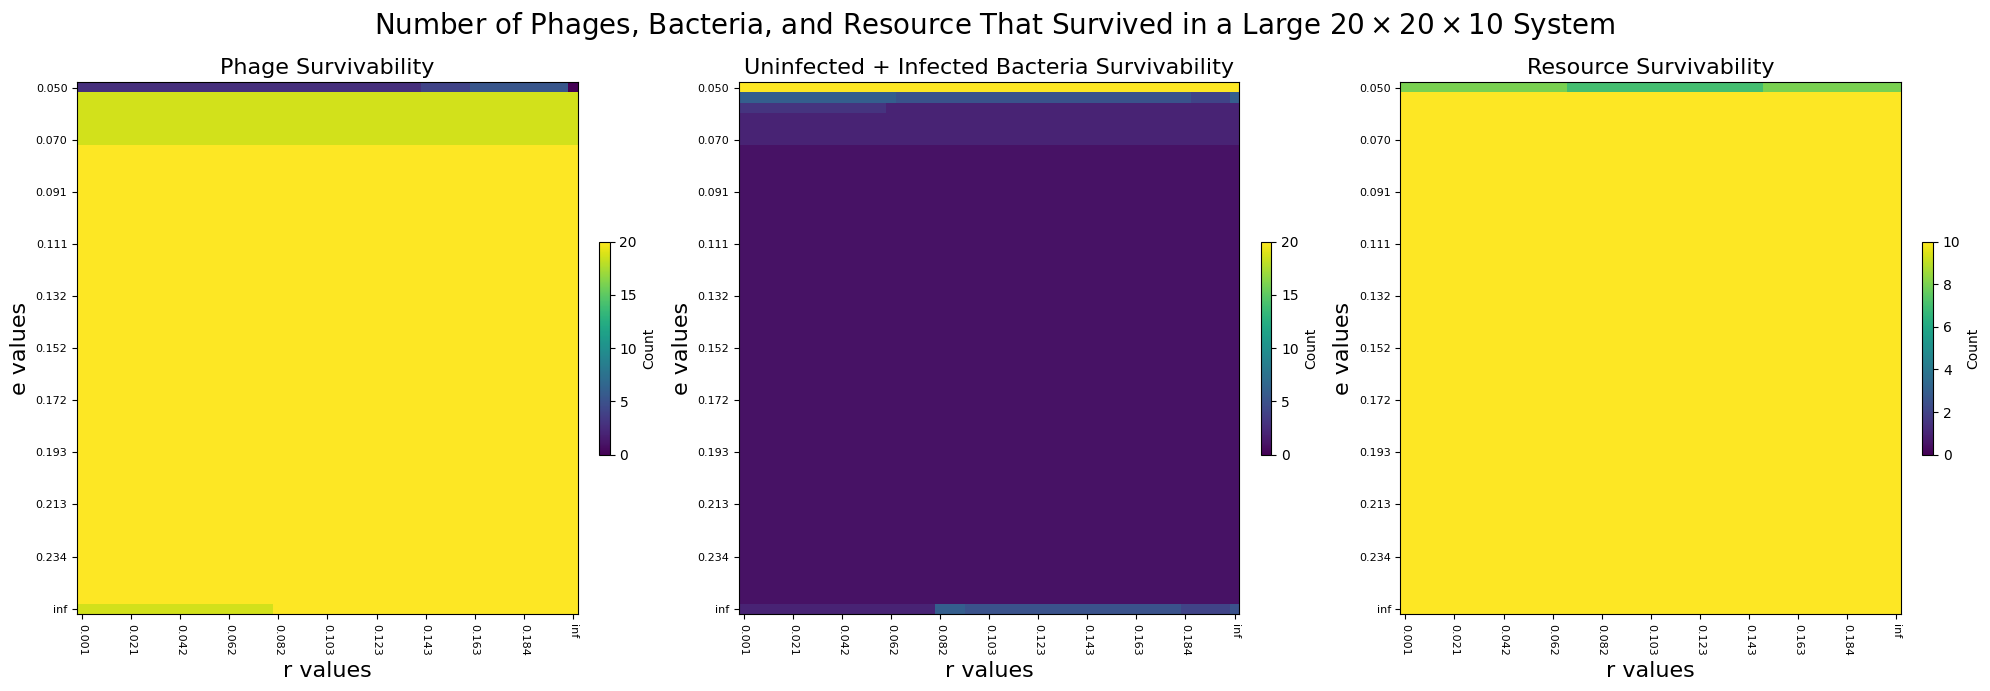

In [7]:
with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])
print(pickle_data['environment_data'])

matrix_phages, matrix_bacteria, matrix_resources = analyze_matrix(pickle_data)
create_plot(matrix_phages, matrix_bacteria, matrix_resources, pickle_data, save_fig='phage_bacteria_resource_survivability.png')
# )